In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
import re
import json
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from keras import backend as K
from keras.layers import Dense, Input, Activation, Conv1D, Flatten
from keras.layers import Dropout, Embedding, MaxPooling1D, Concatenate
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.initializers import Constant
from keras.utils import np_utils

### Reading the input file and storing it in a dataframe

In [4]:
path = '/Users/simrankodwani/Downloads/News_Category_Dataset_v2.json'
list_ = []

with open(path) as files:
    for file in files:
        list_.append(json.loads(file))

In [5]:
data = pd.DataFrame(list_)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


### Merging similar categories

In [6]:
data['category'] = data['category'].replace(['COLLEGE', 'PARENTS', 'ARTS & CULTURE','CULTURE & ARTS', 
                                             'THE WORLDPOST', 'WORLDPOST', 'WEDDINGS','DIVORCE',
                                             'GREEN','STYLE','TASTE','HEALTHY LIVING','FIFTY'],
                                            ['EDUCATION', 'PARENTING', 'ARTS','ARTS','WORLD NEWS', 
                                             'WORLD NEWS','MARRIAGE','MARRIAGE','ENVIRONMENT',
                                             'STYLE & BEAUTY','FOOD & DRINK','HOME & LIVING','LIFESTYLE'])

### Concatenating headline and description columns and convertng the text to lower case

In [7]:
data['headline+description'] = data['headline'] + ' ' + data['short_description']

In [8]:
data['text'] = data['headline+description'].str.lower()

### Tokenizing the text column (headline + description)

In [9]:
#Tokenizing the text
tok = Tokenizer()
tok.fit_on_texts(data.text)

#The texts_to_sequences transforms text to sequence of integers 
data['tokenized_text'] = tok.texts_to_sequences(data.text)

In [10]:
#Dropping any data field which is empty or shorter than 5 words
data['wlen'] = data.tokenized_text.apply(lambda x: len(x))
data = data[data.wlen > 5]

In [11]:
#Setting the maximum length a field an have to 50 and padding sequences to cnvert them to len=50
max_len = 50
X = list(sequence.pad_sequences(data.tokenized_text, maxlen=max_len))

In [12]:
#Converting categories to ids
categories = data.groupby('category').size().index.tolist()
category_int = {}
int_category = {}

for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

data['cat_id'] = data['category'].apply(lambda x: category_int[x])

In [13]:
##Converting the words to word_embeddings
w_index = tok.word_index
embedds = {}

emb = open('glove.6B.100d.txt')
for line in emb:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedds[word] = coefs
emb.close()

print('Unique Tokens: {}' .format(len(w_index)))
print('Total Word Vectors: {}' .format(len(embedds)))

Unique Tokens: 116617
Total Word Vectors: 400000


In [14]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [15]:
# !unzip glove*.zip

In [16]:
# !ls
# !pwd

In [17]:
#Creating an embedding matrix
dim = 100

embedding_matrix = np.zeros((len(w_index) + 1, dim))

for word, i in w_index.items():
    embedding_vector = embedds.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(w_index)+1,
                            dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_len,
                            trainable=False)

In [18]:
#X and Y data 
#X is text column which is tokenized, converted to integers and padded to maximum length
#Y is the array of labelled data converted to one-hot vector
X = np.array(X)
Y = np_utils.to_categorical(list(data.cat_id))

#Splitting the dataset to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

In [19]:
inp = Input(shape=(max_len,), dtype='int32')
embedding = embedding_layer(inp)
k_size = [2, 3, 4, 5]
st = []

for kernel_size in k_size:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    st.append(drop)

merged = Concatenate()(st)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11661800    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 50, 64)       12864       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 64)       19264       ['embedding[0][0]']              
                                                                                              

In [20]:
textcnn = TextCNN.fit(x_train, 
                      y_train, 
                      batch_size=128, 
                      epochs=20, 
                      validation_data=(x_test, y_test))

Epoch 1/20
1245/1245 [==============================] - 121s 96ms/step - loss: 2.0099 - accuracy: 0.4572 - val_loss: 1.5580 - val_accuracy: 0.5735
Epoch 2/20
1245/1245 [==============================] - 112s 90ms/step - loss: 1.6883 - accuracy: 0.5394 - val_loss: 1.4648 - val_accuracy: 0.5981
Epoch 3/20
1245/1245 [==============================] - 116s 93ms/step - loss: 1.6266 - accuracy: 0.5552 - val_loss: 1.4423 - val_accuracy: 0.6064
Epoch 4/20
1245/1245 [==============================] - 118s 95ms/step - loss: 1.5910 - accuracy: 0.5638 - val_loss: 1.4207 - val_accuracy: 0.6136
Epoch 5/20
1245/1245 [==============================] - 124s 100ms/step - loss: 1.5667 - accuracy: 0.5699 - val_loss: 1.4125 - val_accuracy: 0.6141
Epoch 6/20
1245/1245 [==============================] - 123s 99ms/step - loss: 1.5541 - accuracy: 0.5718 - val_loss: 1.3951 - val_accuracy: 0.6192
Epoch 7/20
1245/1245 [==============================] - 129s 104ms/step - loss: 1.5411 - accuracy: 0.5765 - val_loss:

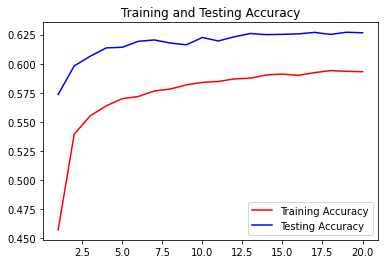

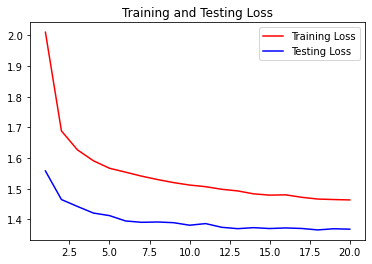

In [21]:
acc = textcnn.history['accuracy']
test_acc = textcnn.history['val_accuracy']
loss = textcnn.history['loss']
test_loss = textcnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and Testing Accuracy')
plt.plot(epochs, acc, 'red', label='Training Accuracy')
plt.plot(epochs, test_acc, 'blue', label='Testing Accuracy')
plt.legend()

plt.figure()
plt.title('Training and Testing Loss')
plt.plot(epochs, loss, 'red', label='Training Loss')
plt.plot(epochs, test_loss, 'blue', label='Testing Loss')
plt.legend()

plt.show()